# Part I: Bag of Words

In [22]:
# Load packages
import pandas as pd  
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords
import nltk.data
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import logging
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load data
train = pd.read_csv("data/labeledTrainData.tsv", 
                    header=0, delimiter="\t", 
                    quoting=3)

test = pd.read_csv("data/testData.tsv", 
                   header=0, delimiter="\t",
                   quoting=3 )

unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0, 
                              delimiter="\t", quoting=3 )

# Split data to test preprocessing and modeling techniques
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['sentiment']), 
                                                    train.sentiment, test_size=0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [3]:
# Download text datasets, including stop words
nltk.download()  

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
def review_to_words(review, string = True, remove_stopwords=True):
    '''
    Function to convert a document to a sequence of words, 
    optionally removing stop words.  
    Returns a list of words.
    '''
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    if string:
        return " ".join(words)
    else:
        return words

In [5]:
# Get list of reviews
clean_train_reviews = [review_to_words(X_train["review"][i]) for i in range(len(X_train))]
clean_test_reviews = [review_to_words(X_test["review"][i]) for i in range(len(X_test))]

In [6]:
# Initialize a bag of words  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

# Fit transform the data
train_feat = vectorizer.fit_transform(clean_train_reviews).toarray()
test_feat = vectorizer.transform(clean_test_reviews).toarray()

In [7]:
# Take a look at the vocabulary
vocab = vectorizer.get_feature_names()

In [ ]:
# Get predicitons
def get_preds(test_feat, train_feat, y_test, y_train, model, title='Random Forest'):
    model.fit(train_feat, y_train)
    preds = model.predict(test_feat)
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return preds

AUC: 0.8343527943153447


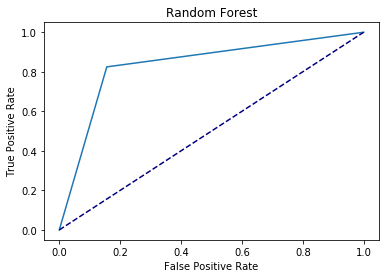

AUC: 0.8445249983995903


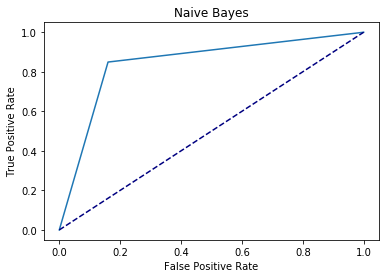

In [11]:
preds_rf = get_preds(test_feat, train_feat, 
                  y_test, y_train, 
                  RandomForestClassifier(n_estimators = 100))

preds_nb = get_preds(test_feat, train_feat, 
                  y_test, y_train, 
                  MultinomialNB(), title='Naive Bayes')

# Part II: Word2Vec

In [13]:
# Download the punkt tokenizer if necessary
nltk.download('punkt')   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    '''
    Split a review into parsed sentences. 
    Returns a list of sentences, where each sentence is a list of words
    '''
    # Remove HTML
    review = BeautifulSoup(review).get_text()
    # Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Get a list of words
            sentences.append(review_to_words(raw_sentence, string=False, 
                                             remove_stopwords=False))
    return sentences

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ritakurban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
sentences = []

for review in X_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

/Users/ritakurban/anaconda3/envs/evamodels/lib/python3.6/site-packages/bs4/__init__.py:302: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/ritakurban/anaconda3/envs/evamodels/lib/python3.6/site-packages/bs4/__init__.py:375: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/ritakurban/anaconda3/envs/evamodels/lib/python3.6/site-packages/bs4/__init__.py:375: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document t

In [15]:
# Set parameters
num_features = 300                   
min_word_count = 40                         
num_workers = 4       
context = 10                                                                                      
downsampling = 1e-3   

# Initialize and train the model
model = Word2Vec(sentences, workers=num_workers,
                 size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)


In [17]:
def makeFeatureVec(words, model, num_features):
    '''Average all of the word vectors in a paragraph'''
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    # ICreate a set of words on voc 
    index2word_set = set(model.wv.index2word)
    # Add feature vectors if they are inside model vocabulary
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Get averages
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Given a set of reviews (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    '''
    # Initialize a counter
    counter = 0
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,
                                                   num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [18]:
# Calculate average feature vectors for training and testing sets,

clean_train_reviews = [review_to_words(review, string=False, remove_stopwords=True) for review in X_train.review]

trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

clean_test_reviews = [review_to_words(review, string=False, remove_stopwords=True) for review in X_test.review]

testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

/Users/ritakurban/anaconda3/envs/evamodels/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


AUC: 0.8382353882593945


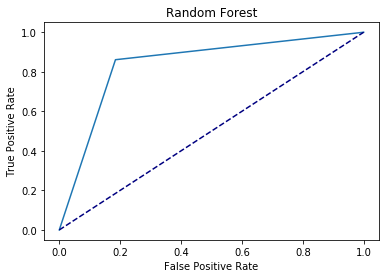

AUC: 0.7370398822098457


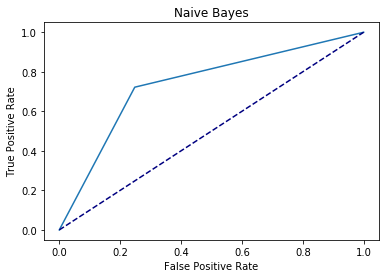

In [24]:
# Get Results
preds_rf1 = get_preds(testDataVecs, trainDataVecs, 
                      y_test, y_train, 
                      RandomForestClassifier(n_estimators = 100))

# Use Gaussian NB because Multinomial doesn't work with negative feature values
preds_nb1 = get_preds(testDataVecs, trainDataVecs, 
                      y_test, y_train, 
                      GaussianNB(), title='Naive Bayes')



## Tf-Idf

This is short for term frequency-inverse document frequency. 

Term frequency (the same as bag of words):  $$\text{Tf} = \frac{\text{number of times term appears in document}}{\text{total number of words in document}}$$

Inverse document frequency measures how rare a term is across all documents (the higher the value, the rarer the word): $$\text{Idf} = \ln\left(\frac{\text{total number of documents}}{\text{number of documents with term in them}}\right)$$

We combine these two to get Tf-Idf as follows:
 $$\text{Tf-idf} = \text{Tf} \times \text{Idf}$$

 https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
 

In [20]:
# TFIDF train set
tfidf_transformer = TfidfTransformer().fit(train_feat)
train_tfidf = tfidf_transformer.transform(train_feat)

# apply tfidf to test set
test_tfidf = tfidf_transformer.transform(test_feat)

AUC: 0.8428189616541835


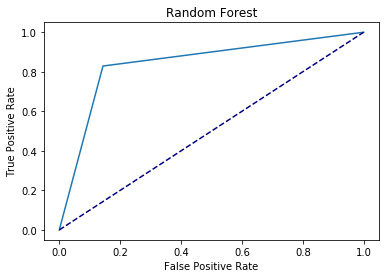

AUC: 0.8478010370654887


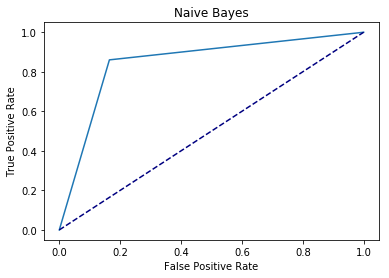

In [26]:
# Get Results
preds_rf2 = get_preds(test_tfidf, train_tfidf, 
                  y_test, y_train, 
                  RandomForestClassifier(n_estimators = 100))

preds_nb2 = get_preds(test_tfidf, train_tfidf, 
                  y_test, y_train, 
                  MultinomialNB(), title='Naive Bayes')